## SONNMF on Swimmer Data

This notebook demonstrates the application of SONNMF (Sum-of-Norms regularized Non-negative Matrix Factorization) to swimmer image dataset and compares it to vanilla NMF.

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.core.main import sonnmf
from sonnmf.core.utils import calculate_gscore
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import h5py  # For HDF5 file handling

In [3]:
def save_h5(filepath, **kwargs):
    """
    Save data to an HDF5 file.

    Parameters:
        filepath (str): Path to save the file.
        kwargs: Data to save.
    """
    with h5py.File(filepath, 'w') as h5file:
        for key, value in kwargs.items():
            h5file.create_dataset(key, data=value)

def load_h5(filepath):
    """
    Load data from an HDF5 file.

    Parameters:
        filepath (str): Path to the file.

    Returns:
        dict: Loaded data.
    """
    data = {}
    with h5py.File(filepath, 'r') as h5file:
        for key in h5file.keys():
            data[key] = h5file[key][:]
    return data

def initialize_matrices(filepath, m, n, rank):
    """
    Initialize W and H, either by loading from a file or generating randomly.

    Parameters:
        filepath (str): Path to the file to load/save the factors.
        m (int): Number of rows in the data matrix.
        n (int): Number of columns in the data matrix.
        rank (int): Rank for the factorization.

    Returns:
        tuple: Initialized W and H factors.
    """
    if os.path.exists(filepath):
        data = load_h5(filepath)
        W_init = data['W_init']
        H_init = data['H_init']
        print("Loaded initial matrices from file.")
    else:
        W_init = np.random.rand(m, rank)
        H_init = np.random.rand(rank, n)
        save_h5(filepath, W_init=W_init, H_init=H_init)
        print("Generated new initial matrices.")
    return W_init, H_init

In [4]:
def plot_separate_H(H, img_size, figsize, fontsize, num_rows=4, normalize_row=False, filename=None):
    """
    Plot separate H matrices (temporal coefficients) as individual subplots.
    
    Parameters:
        H (np.ndarray): H matrix (temporal coefficients).
        img_size (tuple): Image dimensions (height, width).
        figsize (tuple): Figure size.
        fontsize (int): Font size for titles.
        num_rows (int): Number of rows in subplot grid.
        normalize_row (bool): Whether to normalize rows.
        filename (str, optional): Filename to save the plot.
    """
    rank = H.shape[0]
    if normalize_row:
        H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-12)
    
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    num_cols = int(np.ceil(rank / num_rows))
    
    if num_rows > 1:
        fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
        axs = axs.ravel() if num_rows * num_cols > 1 else [axs]
        
        for cnt in range(num_rows * num_cols):
            if cnt < rank:
                img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
                axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
                axs[cnt].axis('off')
                divider = make_axes_locatable(axs[cnt])
                cax = divider.append_axes('right', size='5%', pad=0.1)
                fig.colorbar(img, cax=cax, orientation='vertical')
            else:
                axs[cnt].axis('off')
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        if rank == 1:
            axs = [axs]
        
        for cnt in range(rank):
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
            axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].axis('off')
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

def plot_combined_H(H, img_size, figsize, num_rows=1, normalize_row=False, filename=None):
    """
    Plot combined H matrices (temporal coefficients) as a single concatenated image.
    
    Parameters:
        H (np.ndarray): H matrix (temporal coefficients).
        img_size (tuple): Image dimensions (height, width).
        figsize (tuple): Figure size.
        num_rows (int): Number of rows for arrangement.
        normalize_row (bool): Whether to normalize rows.
        filename (str, optional): Filename to save the plot.
    """
    if normalize_row:
        H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-12)

    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if num_rows > 1:
        num_cols = int(np.ceil(H.shape[0] / num_rows))
        large_mat = np.vstack([np.hstack(H3d[i * num_cols: (i+1) * num_cols]) for i in range(num_rows)])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

def plot_spectral_signatures(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    """
    Plot motion patterns (W matrix columns) for swimmer data.
    
    Parameters:
        W (np.ndarray): W matrix (motion patterns).
        figsize (tuple): Figure size.
        fontsize (int): Font size for titles.
        n_rows (int): Number of rows in subplot grid.
        filename (str, optional): Filename to save the plot.
        scale_y (bool): Whether to scale y-axis uniformly.
        plot_title (str, optional): Title for the entire figure.
    """
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel() if n_rows * n_cols > 1 else [axs]

    for cnt in range(len(axs)):
        if cnt < rank:
            axs[cnt].plot(W[:, cnt], linewidth=3)
            if scale_y:
                axs[cnt].set_ylim([min(0, wmin), wmax])

            axs[cnt].set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].set_xlabel('Pixel Index')
            axs[cnt].set_ylabel('Intensity')
        else:
            axs[cnt].axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25, y=1.02)
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        plt.close()

def merge_images(images_list, filename, delete_images=False):
    """
    Merge multiple images vertically into a single image.
    
    Parameters:
        images_list (list): List of image file paths.
        filename (str): Output filename for merged image.
        delete_images (bool): Whether to delete original images after merging.
    """
    imgs = [Image.open(i) for i in images_list]
    
    # Convert all images to RGB mode to ensure consistency
    imgs = [img.convert('RGB') for img in imgs]
    
    min_img_width = min(i.width for i in imgs)

    total_height = 0
    for i, img in enumerate(imgs):
        if img.width > min_img_width:
            imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.Resampling.LANCZOS)
        total_height += imgs[i].height

    # Create merged image with white background in RGB mode
    img_merge = Image.new('RGB', (min_img_width, total_height), color='white')
    y = 0
    for img in imgs:
        img_merge.paste(img, (0, y))
        y += img.height

    img_merge.save(filename)

    if delete_images:
        for fp in images_list:
            os.remove(fp)

def plot_and_merge(W, H, imgsize, figsize, fontsize, filenames, num_rows, delete=False):
    """
    Create comprehensive plots and merge them into a single image.
    
    Parameters:
        W (np.ndarray): Motion patterns matrix.
        H (np.ndarray): Temporal coefficients matrix.
        imgsize (tuple): Image dimensions.
        figsize (tuple): Figure size.
        fontsize (int): Font size.
        filenames (list): List of filenames for individual plots and final merged image.
        num_rows (int): Number of rows for subplot arrangement.
        delete (bool): Whether to delete individual images after merging.
    """
    plot_spectral_signatures(W, figsize, fontsize=fontsize, n_rows=num_rows, filename=filenames[0])
    plot_separate_H(H, imgsize, figsize=figsize, fontsize=fontsize, num_rows=num_rows, filename=filenames[1])
    plot_combined_H(H, imgsize, figsize=figsize, num_rows=num_rows, filename=filenames[2])
    merge_images(filenames[:3], filenames[3], delete_images=delete)

In [5]:
# Directory setup
data_dir = '../datasets/'
os.makedirs(data_dir, exist_ok=True)

saved_model_dir = '../saved_models/swimmer/'
os.makedirs(saved_model_dir, exist_ok=True)

images_dir = '../images/'
os.makedirs(images_dir, exist_ok=True)

### Loading Swimmer Data

In [6]:
data_filepath = '../datasets/swimmer.h5' # TODO: change X to M
if os.path.exists(data_filepath):
    data = load_h5(data_filepath)
    M = data['X'].astype(np.float64)
else:
    raise FileNotFoundError(f"Dataset not found at {data_filepath}")

m, n = M.shape
img_height, img_width = 20, 11  # Dataset dimensions
print(f"Data matrix shape: {M.shape}")
print(f"Image dimensions: {img_height} x {img_width}")
print(f"Number of spectral bands: {m}")
print(f"Number of pixels: {n}")

Data matrix shape: (256, 220)
Image dimensions: 20 x 11
Number of spectral bands: 256
Number of pixels: 220


### Experiment Parameters and Setup

In [7]:
# Experiment parameters
rank = 50
max_iters = 1000
lambda_reg = 0.5
gamma_reg = 10    

In [8]:
# Initialize W and H matrices
ini_filepath = os.path.join(saved_model_dir, f'rank{rank}_init.h5')
W_init, H_init = initialize_matrices(ini_filepath, m, n, rank)

Loaded initial matrices from file.


### Running Vanilla NMF

In [9]:
# Vanilla NMF
vanilla_filepath = os.path.join(saved_model_dir, f'vanilla_rank{rank}_iters{max_iters}.h5')

if os.path.exists(vanilla_filepath):
    data = load_h5(vanilla_filepath)
    W_vanilla = data['W']
    H_vanilla = data['H']
    print("Loaded vanilla NMF results from file.")
else:
    print("Running vanilla NMF...")
    model = NMF(n_components=rank, init='custom', random_state=42, max_iter=max_iters)
    W_vanilla = model.fit_transform(X=M, W=W_init.copy(), H=H_init.copy())
    H_vanilla = model.components_
    save_h5(vanilla_filepath, W=W_vanilla, H=H_vanilla)
    print("Vanilla NMF completed and results saved.")

Loaded vanilla NMF results from file.


In [10]:
# Create comprehensive visualization for vanilla NMF results
print("Creating comprehensive vanilla NMF visualization...")
filenames_vanilla = [
    os.path.join(images_dir, 'tmp_vanilla_swimmer_w.png'),
    os.path.join(images_dir, 'tmp_vanilla_swimmer_seph.png'), 
    os.path.join(images_dir, 'tmp_vanilla_swimmer_combh.png'),
    os.path.join(images_dir, 'swimmer_vanilla_comprehensive.pdf')
]

plot_and_merge(W_vanilla, H_vanilla, (img_height, img_width), (16, 10), 16, filenames_vanilla, 5, delete=True)
print("Comprehensive vanilla NMF visualization saved.")

Creating comprehensive vanilla NMF visualization...
Comprehensive vanilla NMF visualization saved.
Comprehensive vanilla NMF visualization saved.


### Running SONNMF

In [11]:
# SONNMF
sonnmf_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_gamma{gamma_reg}_iters{max_iters}.h5')

if os.path.exists(sonnmf_filepath):
    data = load_h5(sonnmf_filepath)
    W_sonnmf = data['W']
    H_sonnmf = data['H']
    print("Loaded SONNMF results from file.")
else:
    print("Running SONNMF...")
    W_sonnmf, H_sonnmf, fscores, gscores, hscores, total_scores = sonnmf(
        M, W_init.copy(), H_init.copy(), 
        lam=lambda_reg, gamma=gamma_reg, 
        itermax=max_iters, W_update_iters=10, 
        early_stop=True, verbose=False
    )
    save_h5(sonnmf_filepath, W=W_sonnmf, H=H_sonnmf, 
            fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)
    print("SONNMF completed and results saved.")

Loaded SONNMF results from file.


The following plot corresponds to Figure 10 in the "Sum-of-norms regularized Nonnegative Matrix Factorization" article.

In [12]:
# Create comprehensive visualization for SONNMF results
print("Creating comprehensive SONNMF visualization...")
filenames_sonnmf = [
    os.path.join(images_dir, 'tmp_sonnmf_swimmer_w.png'),
    os.path.join(images_dir, 'tmp_sonnmf_swimmer_seph.png'), 
    os.path.join(images_dir, 'tmp_sonnmf_swimmer_combh.png'),
    os.path.join(images_dir, 'swimmer_sonnmf_comprehensive.pdf')
]

plot_and_merge(W_sonnmf, H_sonnmf, (img_height, img_width), (16, 10), 16, filenames_sonnmf, 5, delete=True)
print("Comprehensive SONNMF visualization saved.")

Creating comprehensive SONNMF visualization...
Comprehensive SONNMF visualization saved.
Comprehensive SONNMF visualization saved.


In [13]:
# Define key component indices for detailed analysis
unique_idxs = [8, 0, 21, 33, 10, 44, 47, 12, 38, 16, 42, 18, 31, 17, 48, 14, 2]
other_idxs = [x for x in range(rank) if x not in unique_idxs]

# Selected vanilla NMF components for comparison
vanilla_selected_idxs = [28, 43, 44]

print(f"Selected {len(unique_idxs)} key SONNMF components for detailed analysis")
print(f"Selected {len(vanilla_selected_idxs)} vanilla NMF components for comparison")

Selected 17 key SONNMF components for detailed analysis
Selected 3 vanilla NMF components for comparison


The following plot corresponds to Figure 3 in the "Sum-of-norms regularized Nonnegative Matrix Factorization" article.

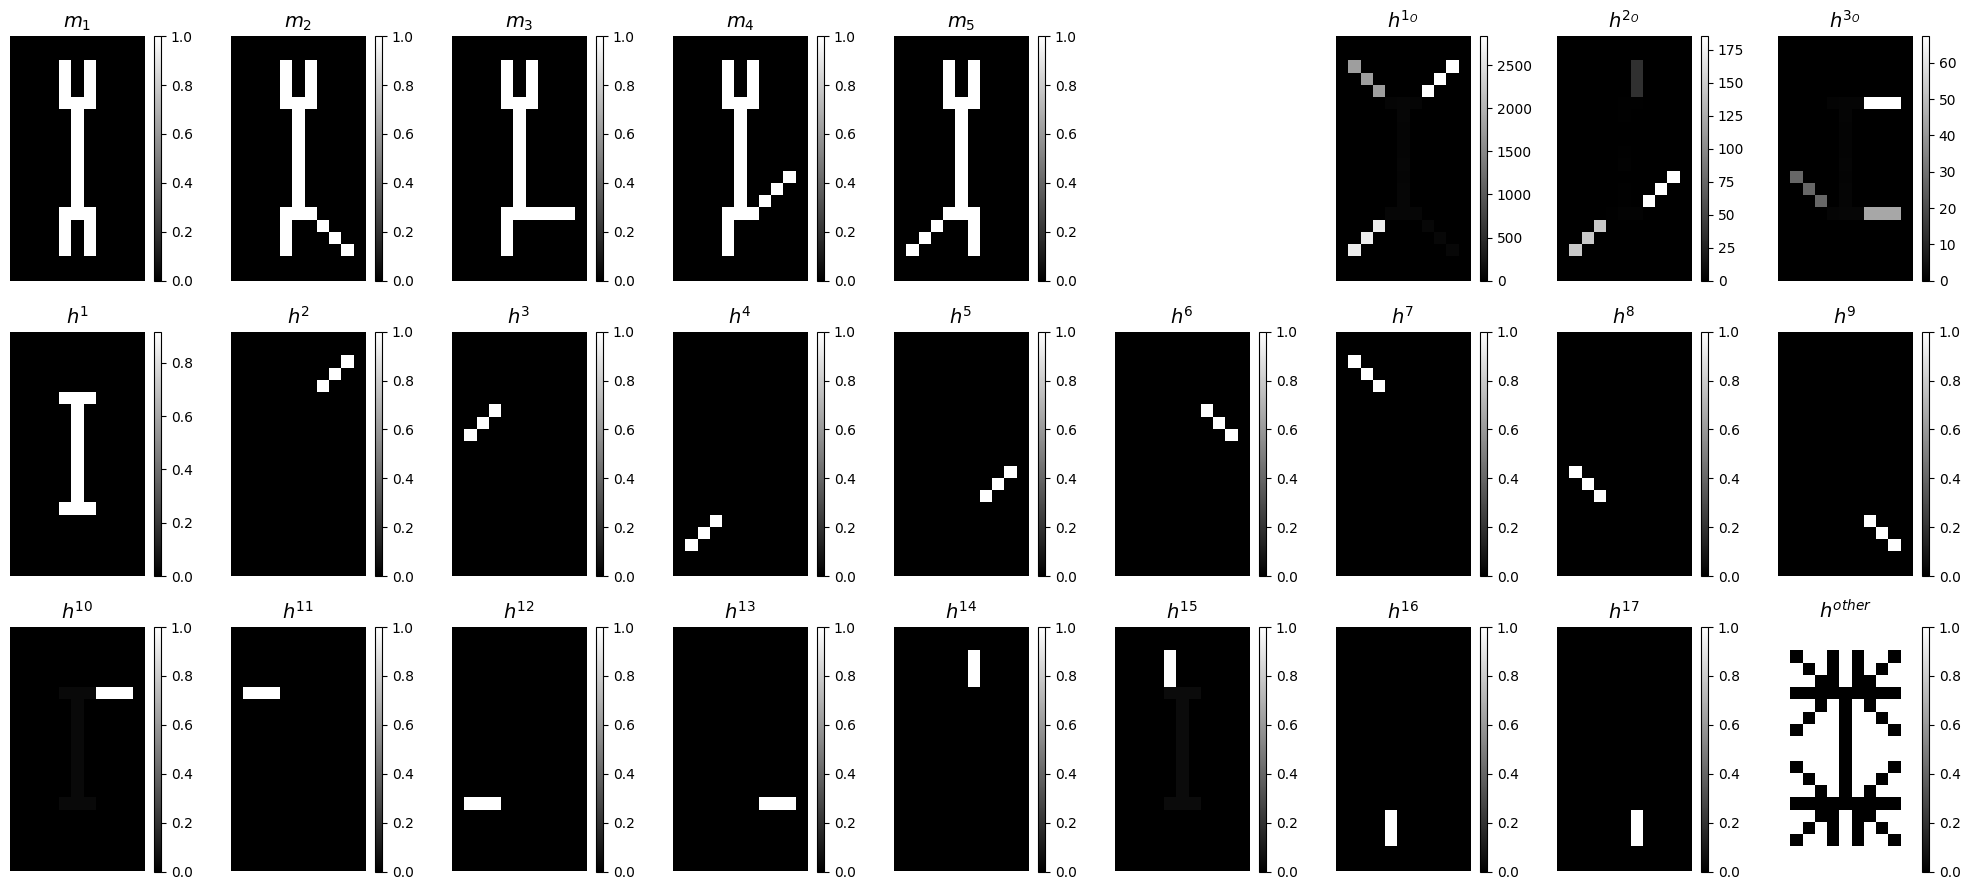

In [14]:
# Create detailed breakdown visualization
num_rows = 3
num_cols = 9
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 9))

# Reshape data for visualization
M3d = M.reshape(-1, img_height, img_width, order='F')
H_sonnmf_3d = H_sonnmf.reshape(-1, img_height, img_width, order='F')
H_vanilla_3d = H_vanilla.reshape(-1, img_height, img_width, order='F')

axs = axs.ravel()

# Row 1: Original video frames (first 5 frames)
for ax_idx in range(5):
    img = axs[ax_idx].imshow(M3d[ax_idx, :, :], cmap='gray')
    axs[ax_idx].set_title(f'$m_{{{ax_idx + 1}}}$', fontsize=14) # indexing from 1
    
    divider = make_axes_locatable(axs[ax_idx])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[ax_idx].axis('off')

# Empty cell to align with next row
axs[5].axis('off')

# Row 2: Selected vanilla NMF components
for ax_idx, comp_idx in enumerate(vanilla_selected_idxs):
    plot_idx = ax_idx + 6
    
    img = axs[plot_idx].imshow(H_vanilla_3d[comp_idx, :, :], cmap='gray')
    axs[plot_idx].set_title(f'$h^{{{ax_idx + 1}_O}}$', fontsize=14) # indexing from 1
    
    divider = make_axes_locatable(axs[plot_idx])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[plot_idx].axis('off')

# Row 3: SONNMF components
for ax_idx, comp_idx in enumerate(unique_idxs):
    plot_idx = ax_idx + 9
    
    if plot_idx < len(axs) - 1:  # Leave space for "other" component
        img = axs[plot_idx].imshow(H_sonnmf_3d[comp_idx, :, :], cmap='gray')
        axs[plot_idx].set_title(f'$h^{{{ax_idx + 1}}}$', fontsize=14)
        
        divider = make_axes_locatable(axs[plot_idx])
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(img, cax=cax, orientation='vertical')
        axs[plot_idx].axis('off')

# Last subplot: Sum of other SONNMF components
if len(axs) > 26:
    img = axs[-1].imshow(H_sonnmf_3d[other_idxs, :, :].sum(axis=0), cmap='gray')
    axs[-1].set_title('$h^{other}$', fontsize=14)
    divider = make_axes_locatable(axs[-1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'swimmer_detailed_breakdown.pdf'), bbox_inches='tight')
plt.show()

### Sum-of-Norms Score Analysis

This analysis evaluates the relative importance of each component using sum-of-norms scores, providing insight into how SONNMF prioritizes different motion patterns in the swimmer video data.

In [15]:
def calculate_columnwise_son_score(W):
    """
    Calculate column-wise sum-of-norms scores for component importance analysis.
    
    Parameters:
        W (np.ndarray): W matrix (motion patterns).
    
    Returns:
        tuple: (sorted_indices, marginal_scores) where indices are sorted by importance
    """
    r = W.shape[1]
    total_son = calculate_gscore(W)
    
    # Calculate marginal contribution of each component
    scores = []
    for i in range(r):
        # Contribution when removing component i
        W_minus_i = np.delete(W, i, axis=1)
        son_minus_i = calculate_gscore(W_minus_i) if W_minus_i.shape[1] > 0 else 0
        marginal_contribution = total_son - son_minus_i
        scores.append(marginal_contribution / total_son if total_son > 0 else 0)
    
    # Sort by importance (descending)
    idx_list = np.argsort(scores)[::-1]
    marginal_scores = np.array(scores)[idx_list]
    
    return idx_list, marginal_scores

# Calculate sum-of-norms scores for SONNMF components
print("Calculating sum-of-norms scores for SONNMF components...")
idx_list, marginal_scores = calculate_columnwise_son_score(W_sonnmf)

# print(f"Most important components (top 10): {idx_list[:10]}")
# print(f"Their relative scores: {marginal_scores[:10]:.4f}")

Calculating sum-of-norms scores for SONNMF components...


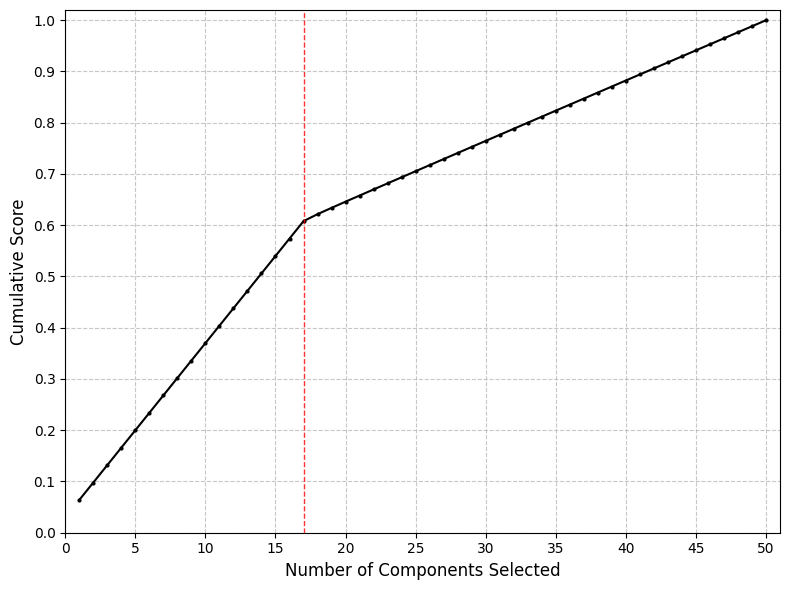

17 components explain 60.80% of the total sum-of-norms score


In [16]:
# Visualize cumulative sum-of-norms scores
cumsum_normalized = np.cumsum(marginal_scores / np.sum(marginal_scores))

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumsum_normalized) + 1), cumsum_normalized, 
         linestyle='-', marker='o', markersize=2, color='black', linewidth=1.5)

plt.xticks(np.arange(0, len(cumsum_normalized) + 1, 5))
plt.xlim(0, len(cumsum_normalized) + 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.7) 

plt.axvline(x=17, color='r', linewidth=1, linestyle='--', alpha=0.8)
# plt.axhline(y=cumsum_normalized[16], color='r', linewidth=1, linestyle=':', alpha=0.6)

plt.ylim((0, 1.02))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xlabel("Number of Components Selected", fontsize=12) 
plt.ylabel("Cumulative Score", fontsize=12)  
# plt.title("Cumulative Sum-of-Norms Score Analysis", fontsize=14)
# plt.legend()

# # Add annotation
# plt.annotate(f'17 components: {cumsum_normalized[16]:.2%}', 
#             xy=(17, cumsum_normalized[16]), xytext=(25, 0.7),
#             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
#             fontsize=10, color='red')

plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'swimmer_marginal_score_analysis.pdf'), bbox_inches='tight')
plt.show()

print(f"17 components explain {cumsum_normalized[16]:.2%} of the total sum-of-norms score")